In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

MASTER = "../outputs/path_a/master.csv"
SUM_TAIL = "../outputs/strategy_filter/summary_tail.csv"
SUM_BASE = "../outputs/strategy_filter/summary.csv"
SUM_DR4  = "../outputs/strategy_filter/summary_dti_dr4.csv"

In [2]:
df = pd.read_csv(MASTER, parse_dates=["date"]).sort_values("date")
df["log_price"] = np.log(df["real_price_index"])
df["fwd_ret_4q"] = df["log_price"].shift(-4) - df["log_price"]
df[["date","dti","real_rate","regime","fwd_ret_4q"]].tail(10)


,date,dti,real_rate,regime,fwd_ret_4q
94,2023-09-30,106.625331,1.695318,0,0.016647
95,2023-12-31,107.105775,2.093802,0,0.010136
96,2024-03-31,107.354601,2.082212,0,0.010730
97,2024-06-30,108.005506,2.142334,0,-0.000768
98,2024-09-30,110.799548,2.602694,0,-0.013882
99,2024-12-31,108.189042,1.930687,0,-0.011954
100,2025-03-31,109.243675,1.590244,0,NaN
101,2025-06-30,112.598457,1.869212,0,NaN
102,2025-09-30,109.287472,1.395426,0,NaN
103,2025-12-31,111.475031,0.896641,0,NaN


In [3]:
tmp = df.dropna(subset=["fwd_ret_4q"])
print("IC(dti, fwd_ret_4q):", tmp["dti"].corr(tmp["fwd_ret_4q"]))
print("IC(real_rate, fwd_ret_4q):", tmp["real_rate"].corr(tmp["fwd_ret_4q"]))
for r in [0,1]:
    sub = tmp[tmp["regime"]==r]
    print(f"IC(dti, fwd_ret_4q | regime={r}):", sub["dti"].corr(sub["fwd_ret_4q"]))


IC(dti, fwd_ret_4q): -0.14468825682720673
IC(real_rate, fwd_ret_4q): -0.10405153105883955
IC(dti, fwd_ret_4q | regime=0): -0.30276011736663616
IC(dti, fwd_ret_4q | regime=1): -0.12570674535631876


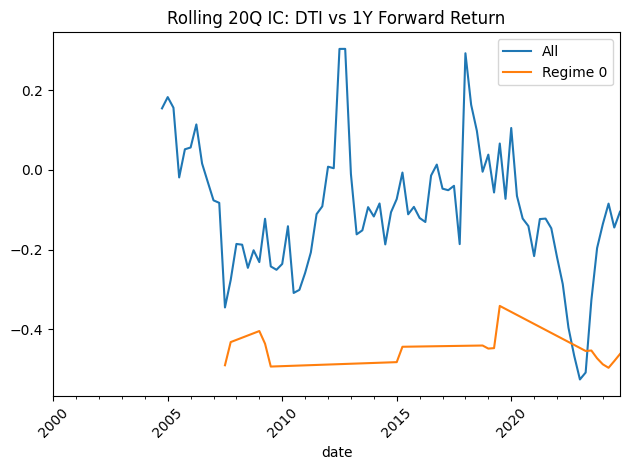

In [9]:
tmp = df.dropna(subset=["dti","fwd_ret_4q","regime"]).copy()
tmp = tmp.set_index("date")

rolling_all = tmp["dti"].rolling(20).corr(tmp["fwd_ret_4q"])

tmp_r0 = tmp[tmp["regime"]==0]
rolling_r0 = tmp_r0["dti"].rolling(20).corr(tmp_r0["fwd_ret_4q"])

plt.figure()
rolling_all.plot(label="All")
rolling_r0.plot(label="Regime 0")
plt.legend()
plt.title("Rolling 20Q IC: DTI vs 1Y Forward Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
pd.read_csv(SUM_TAIL)


,name,mean,std,p05
0,baseline,0.007451,0.06125,-0.115509
1,tail_filter,0.012899,0.05329,-0.070766


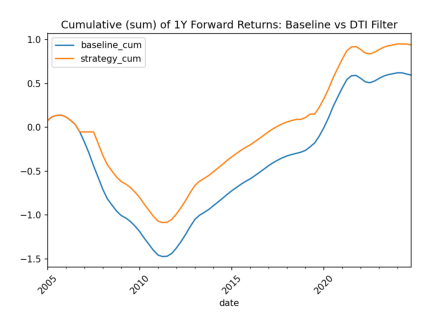

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../outputs/strategy_filter/cum.png")
plt.figure(figsize=(10,4))
plt.imshow(img)
plt.axis("off")
plt.show()


## Leviathan Phase 1 — Executive Summary

**One-liner:**  
Affordability (DTI proxy) is not an unconditional return-seeking factor; it is a **regime-conditional risk filter** that **meaningfully improves left-tail outcomes**, especially when real rates are non-negative.

### What the evidence says
- **Signal direction is structurally negative:** higher DTI is associated with lower 1Y forward real house price returns (IC < 0), and the relationship is **stronger in regime=0** (real_rate ≥ 0).
- **Time stability comes from regime conditioning:** rolling 20-quarter IC stays mostly below zero; conditioning on regime=0 yields a **more consistently negative** correlation than the full sample.
- **Risk-filtering dominates alpha-seeking:** a walk-forward threshold filter that exits exposure when **(regime=0 & DTI is high)** improves the distribution of outcomes—most importantly the **5% left tail (p05)**—without requiring predictive timing.

### Strategy specification (Phase 1 main)
At each quarter-end, choose a DTI threshold using **only past data** (expanding walk-forward) to maximize a tail objective (p05).  
**Hold exposure unless:** `regime == 0` and `DTI > threshold_t`, in which case return is set to 0 (cash).

### Robustness check (extension)
Adding a rate-tightening confirmation (`dr4 = real_rate(t) − real_rate(t−4)`) does **not** dominate the DTI-only tail filter, suggesting DTI already internalizes much of tightening risk. This extension is kept as a robustness reference rather than the main specification.

### Practical interpretation
This system is best understood as a **risk management layer** (when *not* to take housing exposure), rather than a standalone alpha factor (when to buy/sell).
